# Decision trees
#### Author: RAZAFINDRAKOTO Tsiba Nathanaëla

In [2]:
import sys
sys.path.append("..")

import mglearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np

### Decision trees 

In [5]:
# In this first of the assignment, the objective is to develop a classifier to predict the type of a breast cancer (Malignant=1; Benign=0)
# based on a set of features obtained through digitized fine-needle aspirate (FNA) images of a breast mass

# Import breast cancer data
cancer = load_breast_cancer()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

##### Case 1: No specified depth of the tree

In [8]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=0)

# Note: here we do not specify the depth of the tree, so nodes are expanded until all leaves are pure
# or until all leaves contain less than min_samples_split observations (default=2)

# Fit the model
tree.fit(X_train, y_train)

# Check the performance of the model
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.902


##### Case 2: Fixed depth of the tree

In [12]:
# Instantiate the model and specify the maximum depth
tree = DecisionTreeClassifier(max_depth=4, random_state=0)

# Fit the model
tree.fit(X_train, y_train)
 
# Check the performance of the model
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.986
Accuracy on test set: 0.909


##### QUESTION: Why does the model in Case 1 perform slightly worse than that in Case 2?
In Case 1, the model achieved perfect accuracy on the training set (1.00), but less accuracy on the test set (0.90). This suggests that it has overfitted the training data. As the depth of the tree is unlimited, it has learned details specific to the training set, making it less efficient with new data. In Case 2, the model had a maximum depth of 4. Its accuracy on the training set was slightly lower (0.98), but it performed better on the test set (0.90). The depth limit simplified the model, helping it to generalize better to new data. For this reason, the model in Case 2 performed better on the test set.


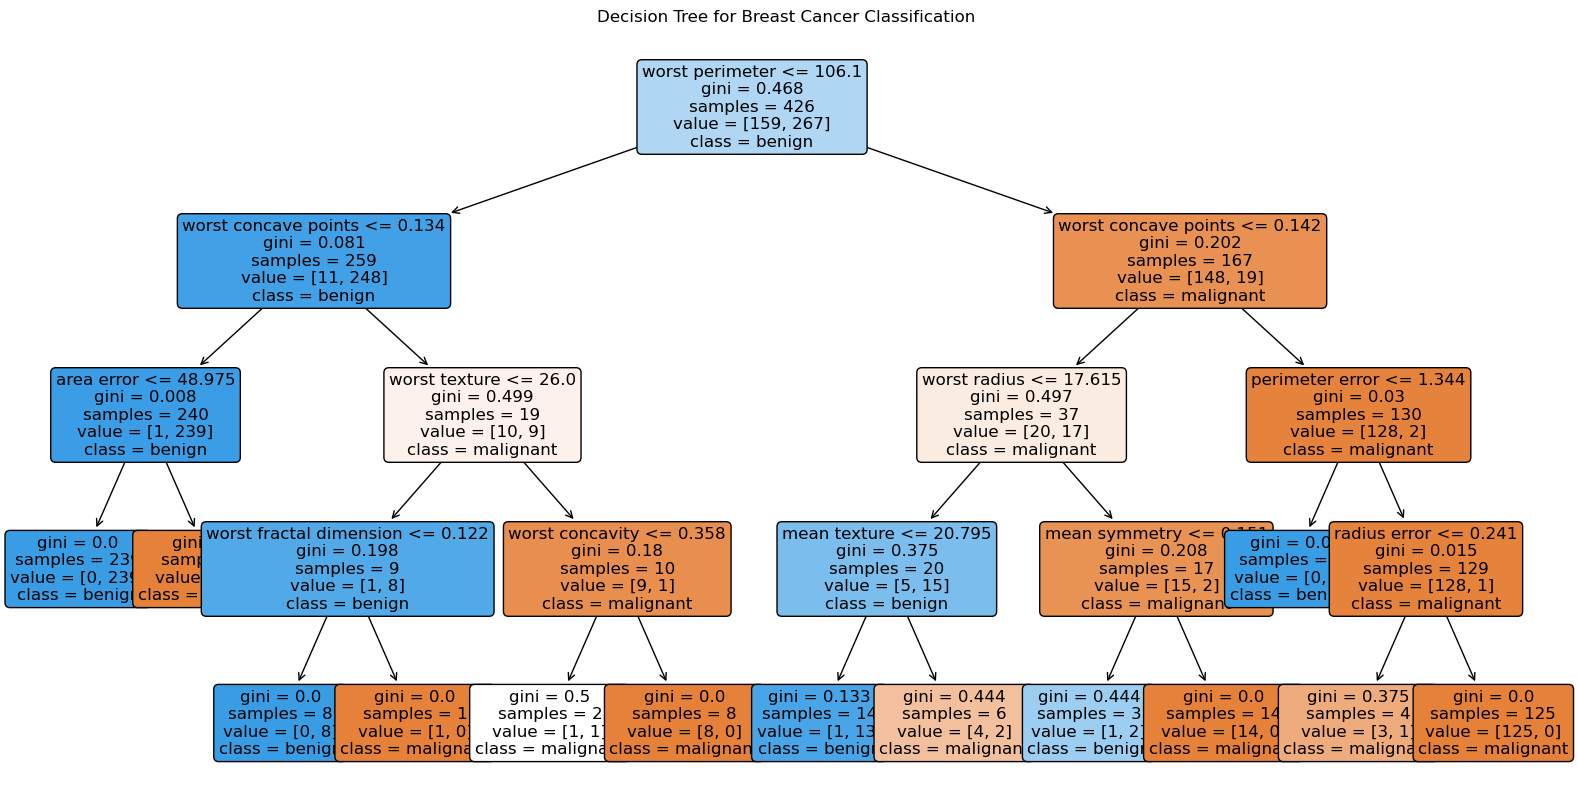

In [15]:
# Plot the tree
plt.figure(figsize=(20, 10)) 
plot_tree(tree, 
          filled=True,  
          feature_names=cancer.feature_names,  
          class_names=cancer.target_names,  
          rounded=True,  
          fontsize=12)  
plt.title("Decision Tree for Breast Cancer Classification")
plt.show()

# Compute feature importances
# Note: feature importance helps to understand which features are most important for prediction
# (very important for model accountability and explicability - more on this below in the final exercise)

Feature importances:
[0.         0.01558601 0.         0.         0.         0.
 0.         0.         0.01150064 0.         0.00253726 0.
 0.01023272 0.01043016 0.         0.         0.         0.
 0.         0.         0.03848579 0.03087626 0.75708572 0.
 0.         0.         0.00418952 0.10976588 0.         0.00931004]


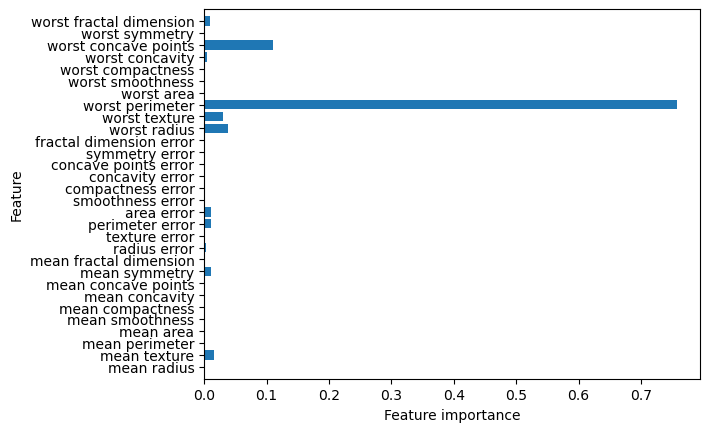

In [18]:
# Report the feature importances
print("Feature importances:")
print(tree.feature_importances_)

# ...or plot them
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

##### QUESTION: What are the three most important features of this model?
The three features with the highest importance values, indicating they contribute the most to the model’s decision-making process, are:
Worst perimeter (importance ~ 0.757)
Worst concave points (importance ~ 0.109)
worst radius (importance ~ 0.038)
These features have the largest bars in the chart, showing they play a major role in determining whether a tumor is classified as malignant or benign.  

##### How is Feature Importance Calculated?
Feature importance in a decision tree is calculated based on impurity decrease, which measures how much a feature reduces uncertainty (impurity) in the data. In classification trees, this impurity is often quantified using metrics like Gini impurity or entropy. Each time a feature is used to split the data at a node, it contributes to an impurity reduction. The model calculates the decrease in impurity for each feature at every split where it is used and sums these reductions across the entire tree. These summed values are then normalized to produce relative importance scores, with higher scores indicating greater importance. In this model, for example, the feature "Worst Perimeter" had the largest decrease in impurity, making it the most significant predictor for classifying breast cancer.

### Cost-complexity pruning

In [31]:
# Import the data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Initialize the model before computing the pruning path
tree = DecisionTreeClassifier(random_state=0)

# Calculate the sequence of possible alpha values
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas   

# Some notes:
# - alpha is the tuning parameters for complexity:
#     - A small alpha value allows the tree to have many leaves, potentially leading to overfitting the data
#     - A larger alpha value results in more pruning, simplifying the tree but potentially underfitting the data

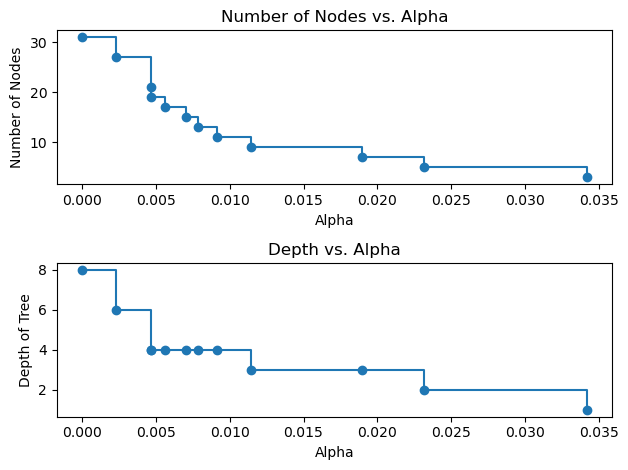

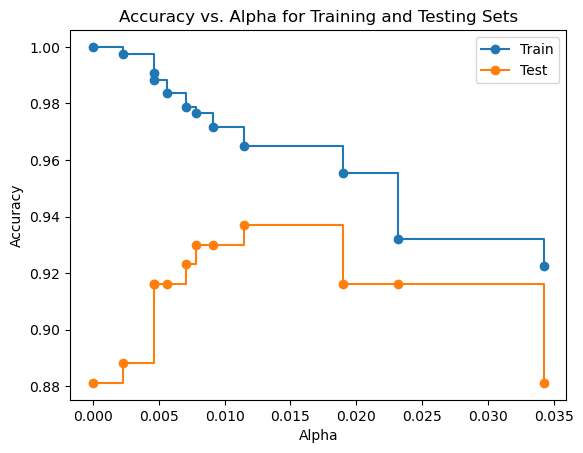

In [33]:
# Fit different trees for each value of alpha
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)

# Remove the trivial tree with only one node
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Plot the number of nodes and depth of the tree for each value of alpha
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Number of Nodes vs. Alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of Tree")
ax[1].set_title("Depth vs. Alpha")
fig.tight_layout() 

# Check the performance of the models
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. Alpha for Training and Testing Sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="Train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="Test", drawstyle="steps-post")
ax.legend()
plt.show()

##### QUESTION: Is this plot consistent with your expectations? Why?
Yes, this plot is consistent with my expectations, and here’s why:
- reduction in complexity: As expected, the number of nodes and the tree depth both decrease as alpha increases. This indicates progressive pruning of the tree, which aligns with the idea that a higher alpha encourages the tree to simplify by removing branches.
- trade-off between Overfitting and Underfitting: The accuracy on the training set gradually decreases with higher alpha, which makes sense because a simpler tree cannot capture all the details of the training data.
The accuracy on the test set initially improves as alpha increases, which shows better generalization. However, at a certain point, as alpha continues to grow, the accuracy on the test set starts to drop, indicating underfitting. This pattern is consistent with the theory that some pruning can reduce overfitting, but excessive pruning leads to a loss of important information and, thus, underfitting.

These results align with the theoretical expectations for cost-complexity pruning. The point where test accuracy peaks represents the optimal balance between tree complexity and generalization ability. This corresponds to the idea that a certain level of simplification helps improve model performance on unseen data, but beyond this optimal point, the model becomes too simple and loses predictive power.

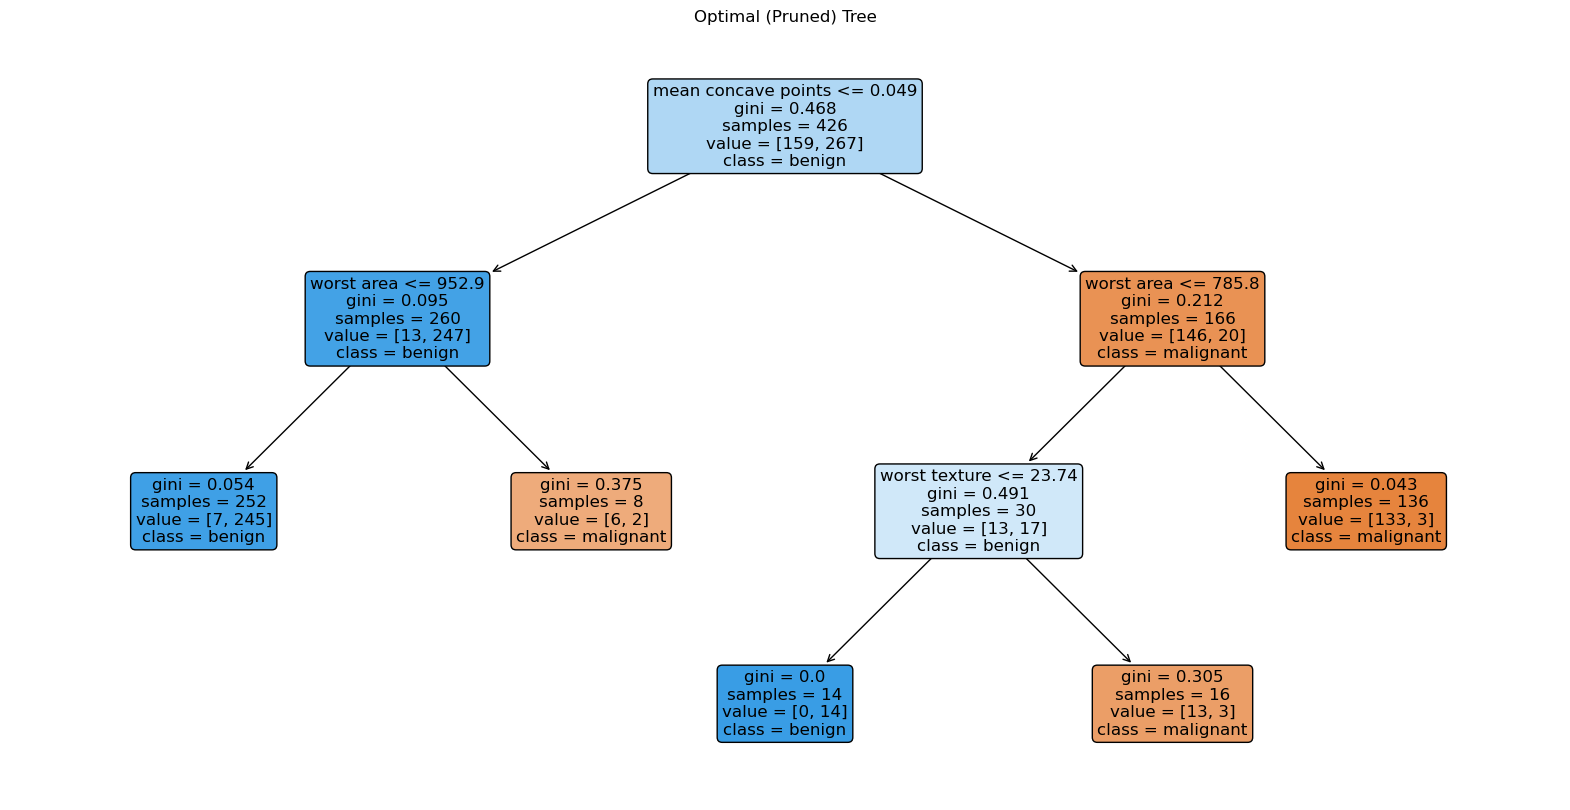

In [36]:
# Choose the tree with the optimal alpha 
optimal_alpha_index = np.argmax(test_scores) 
optimal_tree = trees[optimal_alpha_index]

# ...and plot the optimal tree
plt.figure(figsize=(20, 10))
plot_tree(optimal_tree, 
          filled=True, 
          feature_names=cancer.feature_names, 
          class_names=cancer.target_names, 
          rounded=True, 
          fontsize=12)
plt.title("Optimal (Pruned) Tree")
plt.show()


##### QUESTION: Compare this tree with the unpruned tree. What can you conclude?
The pruned tree is simpler, with fewer levels and branches than the unpruned tree, which is deeper and captures more details, increasing the risk of overfitting. The unpruned tree uses a larger variety of features across multiple branches, including minor details that don’t significantly enhance predictive power. In contrast, the pruned tree focuses on fewer, more influential features, making it easier to interpret and reducing unnecessary splits. Overall, pruning helps the model generalize better to new data by balancing accuracy and simplicity, leading to a more stable and robust model.


### Random Forest

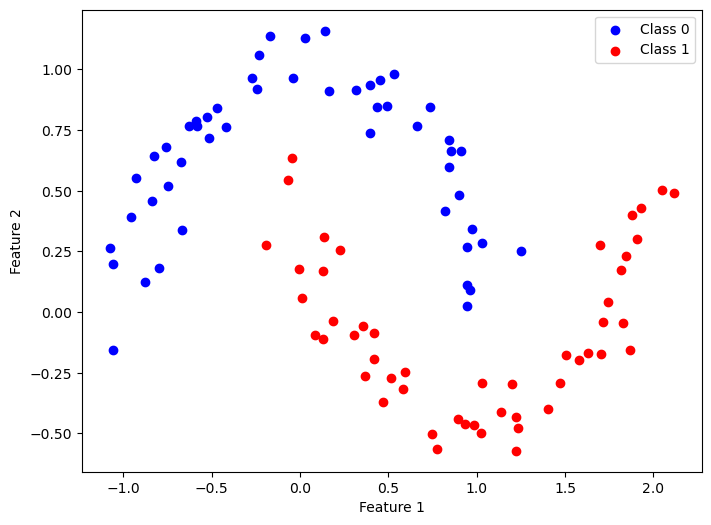

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# 'make_moons' is a synthetic dataset generator:
#  - it allows us to generate classes in two intersecting semicircles (or moons)
#  - the noise modifies the shape of the moons

X, y = make_moons(n_samples=100, noise=0.10, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [45]:
# Instantiate the model
forest = RandomForestClassifier(n_estimators=5, max_features='sqrt', random_state=2)


##### QUESTION: What do 'n_estimators' and 'max_features' stand for?
'n_estimators refers' to the number of trees in the forest. Here, n_estimators=5 means the model will use 5 decision trees.
'max_features' determines the number of features each tree considers at each split. With max_features='sqrt', each tree will randomly select the square root of the total features for splitting, which helps reduce overfitting and improve generalization.

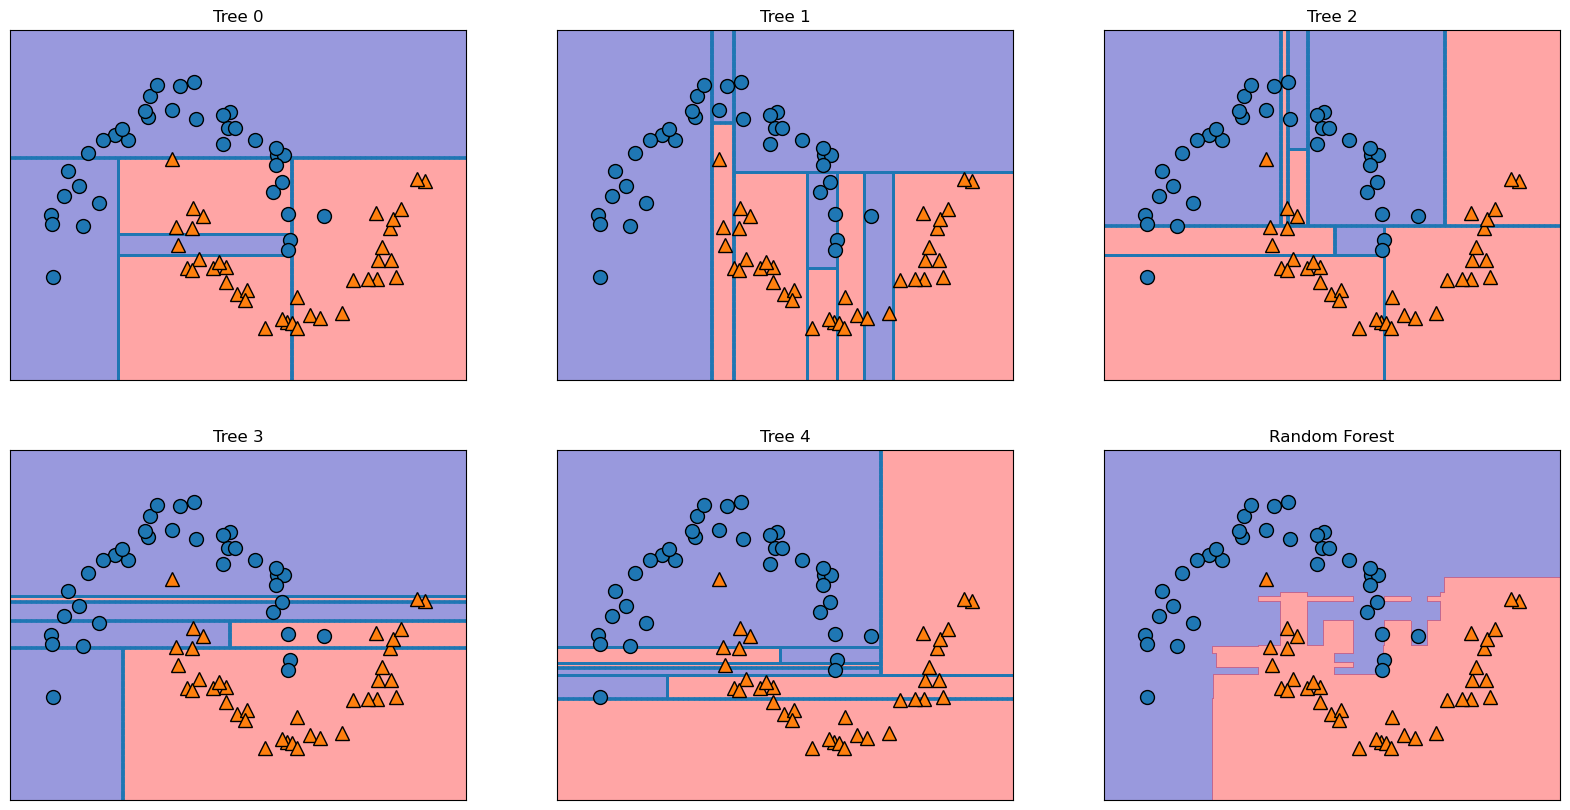

In [48]:
# Fit the model 
forest.fit(X_train, y_train)

# Plot the decision boundaries of the individual trees and the final decision boundary produced by the full random forest
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

##### QUESTION: Why does each individual tree produce a different decision boundary?
Each individual tree produces a different decision boundary due to the randomness introduced during the training process in a random forest. There are two main sources of this randomness:
- Bootstrap Sampling:each tree is trained on a different subset of the training data, chosen through a process called bootstrap sampling. This means that each tree sees a slightly different set of samples, leading to variations in how the decision boundaries are formed.
- Random Feature Selection: at each split, each tree considers only a random subset of the features (as specified by max_features). This forces the trees to rely on different features for making splits, which also contributes to diverse decision boundaries across the individual trees.

These variations help to decorrelate the trees, making the final random forest model more robust. 

In [51]:
# Now let's apply random forest to the breast cancer dataset 
# Note that a common practice is to set n_estimators > 100
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=0)
forest.fit(X_train, y_train)

# Check the performance of the model
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


#### QUESTION: Is the performance of the random forest superior to that of the single tree? 
Yes, the performance of the random forest is superior to that of the single decision tree. Here’s why:
- Accuracy Comparison: The random forest achieved an accuracy of 1.000 on the training set and 0.972 on the test set.
In the earlier decision tree results, the single tree had a perfect accuracy (1.000) on the training set but a lower test accuracy (around 0.909 and 0.902).
- Generalization: While both models overfit the training data with high accuracy, the random forest performs better on the test set, indicating superior generalization to new data. This improvement is due to the ensemble effect: the random forest combines predictions from multiple trees, which reduces overfitting and provides a more stable and reliable model.
- Robustness: The random forest leverages multiple trees, each with different random subsets of data and features, making it less likely to capture noise or irrelevant details. A single decision tree is more susceptible to overfitting specific patterns or noise in the training data, which can lead to lower accuracy on unseen data.

#### Plot the training and test errors (or accuracy) versus the number of trees (n_estimators). What can you conclude?

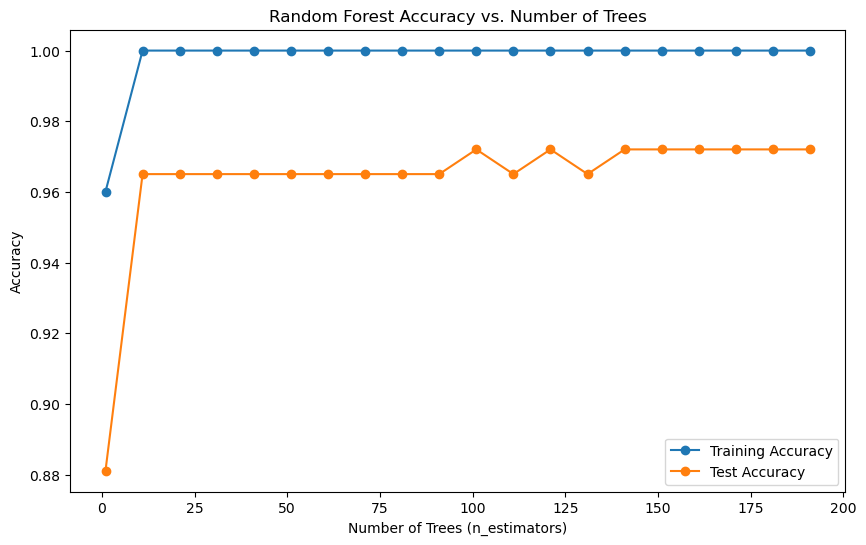

In [70]:
# Load the breast cancer data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Define a range of values for n_estimators
n_estimators_range = range(1, 201, 10)  # For example, from 1 to 200 with increments of 10

# Loop over different values of n_estimators
for n_estimators in n_estimators_range:
    # Initialize and fit the RandomForest model with the current n_estimators
    forest = RandomForestClassifier(n_estimators=n_estimators, max_features='sqrt', random_state=0)
    forest.fit(X_train, y_train)
    
    # Record the accuracy on the training and test sets
    train_accuracies.append(forest.score(X_train, y_train))
    test_accuracies.append(forest.score(X_test, y_test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.legend()
plt.show()

Training Accuracy: It remains consistently high, close to 1.0, across all values of n_estimators. This shows that the model can perfectly fit the training data, as expected with an ensemble method like random forests.

Test Accuracy: Test accuracy increases rapidly at first, reaching around 0.97 quickly. After this point, it fluctuates slightly as more trees are added, indicating small variations in performance. However, the overall accuracy level remains close to 0.97, suggesting that more trees only provide minimal improvements.
We can conclude that the random forest model reaches robust generalization fairly quickly, and additional trees only offer slight variations rather than significant performance boosts.

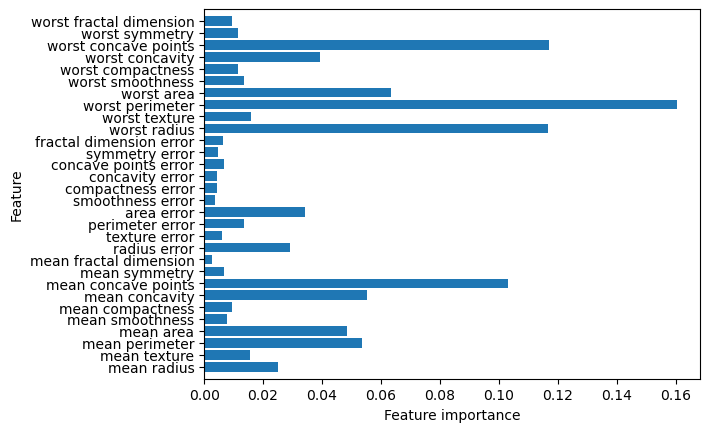

In [63]:
# Also here we can report the feature importance
plot_feature_importances_cancer(forest)

### (Gradient) Boosting

In [60]:

from sklearn.ensemble import GradientBoostingClassifier

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Instantiate the model
gbrt = GradientBoostingClassifier(random_state=0)

# Fit the model
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

# Set a specific depth for the tree (in this case a stump)
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set (depth = 1): {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set (depth = 1): {:.3f}".format(gbrt.score(X_test, y_test)))

# Set a specific learning rate
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set (learning rate = 0.01): {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set (learning rate = 0.01): {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965
Accuracy on training set (depth = 1): 0.991
Accuracy on test set (depth = 1): 0.972
Accuracy on training set (learning rate = 0.01): 0.988
Accuracy on test set (learning rate = 0.01): 0.958


##### QUESTION: 
- Use 'GridSearchCV' to find the find the optimal values for max_depth (depth of the tree) and learning_rate 


In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Définir les valeurs de paramètres à tester
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1]
}

# Initialiser le modèle
gbrt = GradientBoostingClassifier(random_state=0)

# Configurer GridSearchCV avec le modèle, le paramètre grid, et une validation croisée
grid_search = GridSearchCV(gbrt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et la précision associée
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation accuracy: {:.3f}".format(grid_search.best_score_))

# Tester les meilleurs paramètres sur l'ensemble de test
best_model = grid_search.best_estimator_
print("Test set accuracy with best parameters: {:.3f}".format(best_model.score(X_test, y_test)))

Best parameters: {'learning_rate': 0.5, 'max_depth': 1}
Best cross-validation accuracy: 0.972
Test set accuracy with best parameters: 0.979


- Implement two other popular boosting techniques: AdaBoost (Adaptive Boosting) and XGBoost (Extreme Gradient Boosting)

In [82]:
from sklearn.ensemble import AdaBoostClassifier

# Initialiser et entraîner le modèle AdaBoost en utilisant SAMME
adaboost = AdaBoostClassifier(n_estimators=50, random_state=0, algorithm='SAMME')
adaboost.fit(X_train, y_train)

# Vérifier les performances
print("AdaBoost - Accuracy on training set: {:.3f}".format(adaboost.score(X_train, y_train)))
print("AdaBoost - Accuracy on test set: {:.3f}".format(adaboost.score(X_test, y_test)))

AdaBoost - Accuracy on training set: 1.000
AdaBoost - Accuracy on test set: 0.944


In [84]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 653.6 kB/s eta 0:03:12
   ---------------------------------------- 0.2/124.9 MB 2.4 MB/s eta 0:00:53
   ---------------------------------------- 1.0/124.9 MB 7.6 MB/s eta 0:00:17
    --------------------------------------- 2.5/124.9 MB 16.0 MB/s eta 0:00:08
   - -------------------------------------- 4.7/124.9 MB 23.0 MB/s eta 0:00:06
   -- ------------------------------------- 6.9/124.9 MB 29.5 MB/s eta 0:00:05
   --- ------------------------------------ 10.2/124.9 MB 36.3 MB/s eta 0:00:04
   --- ------------------------------------ 12.2/124.9 MB 59.5 MB/s eta 0:00:02
   ---- ----------------------------------- 14.7/124.9 MB 65.6 MB/s eta 0:00:02
   ----- ---------------------------------- 18.6/124.9 MB 65.6 MB/s eta 0:00:02
   ------- -------------------------------- 22.0/124.9 MB 72.6 MB

In [90]:
import xgboost as xgb
from xgboost import XGBClassifier

# Initialiser et entraîner le modèle XGBoost sans `use_label_encoder`
xgboost = XGBClassifier(random_state=0, eval_metric='logloss')
xgboost.fit(X_train, y_train)

# Vérifier les performances
print("XGBoost - Accuracy on training set: {:.3f}".format(xgboost.score(X_train, y_train)))
print("XGBoost - Accuracy on test set: {:.3f}".format(xgboost.score(X_test, y_test)))

XGBoost - Accuracy on training set: 1.000
XGBoost - Accuracy on test set: 0.972


### Exercise: marketing campaign to incentivize customers to subscribe a term deposit

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [142]:
# Charger les données 
data = pd.read_csv('C:\\Users\\natha\\Downloads\\3nd_assignment\\term_deposit.csv')

# Supprimer la colonne "Unnamed: 0"
data = data.drop(columns=["Unnamed: 0"])

# Afficher les premières lignes pour vérifier
print(data.head())

  deposit  age         job  marital  education  balance housing  campaign  \
0     yes   59      admin.  married  secondary     2343     yes         1   
1     yes   56      admin.  married  secondary       45      no         1   
2     yes   41  technician  married  secondary     1270     yes         1   
3     yes   55    services  married  secondary     2476     yes         1   
4     yes   54      admin.  married   tertiary      184      no         2   

   duration  
0      1042  
1      1467  
2      1389  
3       579  
4       673  


In [124]:
# Convertir les variables catégorielles en numériques
data = pd.get_dummies(data, drop_first=True)

# Séparer les features (X) et la cible (y)
X = data.drop('deposit_yes', axis=1)  # 'deposit_yes' est la variable cible après conversion en dummies
y = data['deposit_yes']

In [134]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# Modèles à tester
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0)
}

# Boucle sur chaque modèle pour entraîner et évaluer
for name, model in models.items():
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Faire des prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilités nécessaires pour l'AUC
    
    # Calculer la matrice de confusion et l'AUC
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Afficher les résultats
    print(f"{name} - Confusion Matrix:\n", cm)
    print(f"{name} - AUC: {auc:.3f}\n")

Decision Tree - Confusion Matrix:
 [[1049  420]
 [ 403  919]]
Decision Tree - AUC: 0.705

Random Forest - Confusion Matrix:
 [[1140  329]
 [ 271 1051]]
Random Forest - AUC: 0.855

Gradient Boosting - Confusion Matrix:
 [[1162  307]
 [ 271 1051]]
Gradient Boosting - AUC: 0.865



#### ANALYSES
### Arbre de Décision
Matrice de Confusion :
- Vrais négatifs : 1049
- Faux négatifs : 403
- Faux positifs : 420
- Vrais positifs : 919


L'arbre de décision présente un nombre relativement élevé de faux positifs (420) et de faux négatifs (403). Cela montre que le modèle a des difficultés à distinguer efficacement entre les clients susceptibles de souscrire et ceux qui ne le sont pas.

L’AUC de 0.705 indique que ce modèle a une capacité modérée de discrimination, mais il laisse beaucoup de place à l'amélioration. Il est possible que l’arbre de décision, en tant que modèle unique et moins complexe, soit trop simpliste pour capturer les nuances des données.

### Random forest
Matrice de Confusion :
- Vrais négatifs : 1140
- Faux négatifs : 271
- Faux positifs : 329
- Vrais positifs : 1051


La forêt aléatoire réduit de manière significative le nombre de faux positifs et de faux négatifs par rapport à l'arbre de décision. Elle parvient à mieux identifier les clients qui souscriront (1051 vrais positifs), et ceux qui ne le feront pas (1140 vrais négatifs).

Avec une AUC de 0.855, ce modèle montre une amélioration notable en termes de capacité de discrimination. Cela reflète la robustesse de la forêt aléatoire, qui utilise la moyenne des prédictions de nombreux arbres, permettant une meilleure généralisation et un taux d'erreur plus bas.


### Gradient Boosting
Matrice de Confusion :
- Vrais négatifs : 1162
- Faux négatifs : 271
- Faux positifs : 307
- Vrais positifs : 1051


Le modèle de Gradient Boosting offre les meilleures performances globales. Avec 1162 vrais négatifs et 1051 vrais positifs, il parvient à réduire davantage les faux positifs (307), tout en maintenant les faux négatifs à un niveau bas (271).

L’AUC de 0.865 fait du Gradient Boosting le modèle le plus performant parmi les trois testés. Cette AUC élevée montre une excellente capacité à distinguer entre les classes, grâce à l'ajustement progressif des arbres successifs pour corriger les erreurs des arbres précédents.

### Conclusion et recommandations
Le Gradient Boosting est le modèle le plus adapté pour prédire la souscription aux dépôts à terme. Il présente le meilleur équilibre entre la précision de classification et la capacité à minimiser les erreurs de type faux positifs et faux négatifs.
L’utilisation du Gradient Boosting permettra à la banque d’identifier plus efficacement les clients potentiellement intéressés par les dépôts à terme, réduisant ainsi le coût des campagnes marketing et augmentant leur efficacité.
